Se aborda en esta primera parte del proyecto final *el problema de la determinación del redshift*.

Se muestra el mejor código pensado para resolver este problema y que en cuya arquitectura sean puestos en práctica los diferentes temas abordados a lo largo del curso.

Se dividirá el código en bloques con una tarea diferente, indicando su función y sus implicaciones.

Elaborado por: Oscar Raúl Sánchez Padilla

In [1]:
# BLOQUE 1: IMPORTACIONES Y CONFIGURACIÓN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Servirá para separar los datos en train y test, hará la validación cruzada más delante, Normalizará y/o escalará los datos y calculará métricas.

#Usaremos la siguiente librería para la cross-validation
from sklearn.model_selection import train_test_split, KFold  

#StandardScaler estandarizará las características de tus datos. Evitará darles pesos diferentes a datos de diferentes tamaños o magnitudes.
#RobustScaler nos funcionara como alternativa a StandardScaler que maneja mejor outliers(valores atipicos o fuera de lo normal)
from sklearn.preprocessing import StandardScaler, RobustScaler

#Las siguientes funciones servirán para evaluar qué tan bueno será nuestro modelo de regresión comparando las predicciones con los valores reales. Son métricas de rendimiento.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TensorFlow y Keras
import tensorflow as tf

# Las componentes principales para construir y entrenar redes neuronales:
from tensorflow.keras import layers, models, callbacks, regularizers

# Usamos el siguiente algoritmo de optimización para entrenamiento de las redes neuronales:
from tensorflow.keras.optimizers import Adam

# Para reproducibilidad fijamos los numeros "aleatorios" para que siempre sean iguales.
# Esto es útil para saber si los cambios son por mi código y no por azar. 
np.random.seed(42)
tf.random.set_seed(42) #Usamos el número 42 como convención dentro del mundo de la programación, en general puede ser cualquier numero

# Esto hará que nuestras gráficas se vean más presentables (No afecta al código en si mismo)
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# BLOQUE 2: CARGA Y PREPROCESAMIENTO DE DATOS

# Rutas de tus archivos (guardados localmente)
csv_path = r'C:\Users\op354\OneDrive\Documentos\Oscar\UG\Repositorio Github\ejerciosytareas-Oscarraul28\balanced_spectra_features.csv'
npz_path = r'C:\Users\op354\OneDrive\Documentos\Oscar\UG\Repositorio Github\ejerciosytareas-Oscarraul28\balanced_spectra_flux.npz'

# Carga de datos
print(" * Cargando datos...")
df = pd.read_csv(csv_path) # Lee el archivo CSV y lo convierte en un DataFrame (tabla de pandas)
npz = np.load(npz_path, allow_pickle=True) # Carga el archivo NPZ (formato comprimido de NumPy). Es como un diccionario que contiene arrays.
targetids = npz['targetids'] # Extrae la lista de IDs de los objetos astronómicos
flujo_arr = npz['flux_arrays'] # Extrae los espectros (arrays de flujo luminoso), donde cada espectro es un array de muchisimos pixeles

print(f"    CSV cargado: {df.shape}") # Aquí van los datos pequeños
print(f"    NPZ cargado: {len(flujo_arr)} espectros") # Y aquí los datos grandes

# Construir dataset alineando CSV con NPZ. Esto es muy importante porque...
X_list = [] # Aquí se guardan los espectros (features)
y_list = [] # Aquí se guardan los redshifts!! Que son los targets!!
espectro_lista = [] #Aquí se guardan los tipos espectrales

#Aqui hacemos el loop por cada objeto, donde terminamos obteniendo tanto el indice como su respectivo valor
for i, tid in enumerate(targetids):
    row = df.loc[df['targetid'] == tid] #Aquí busca la fila en el CSV que tenga ese targetid
    if row.empty:
        continue #Si no encuentra el objeto en el CSV salta al siguiente
    redshift = row['redshift'].values[0] #Toma de la columna de redshift el primer (y unico) valor
    if pd.isna(redshift):
        continue #Aquí solo nos aseguramos de tener datos completos. Si el redshift es NaN, lo salta.
    X_list.append(flujo_arr[i])
    y_list.append(float(redshift))
    espectro_lista.append(row['spectype'].values[0])

# Guardamos todo:
X = np.asarray(X_list)         # Espectros 
y = np.asarray(y_list)         # Redshift (target)
spectypes = np.asarray(espectro_lista)  # Tipos espectrales (GALAXY, QSO, STAR,...)

print(f"\n * Dataset construido:")
print(f"   - Espectros: {X.shape}") #Muestra la cantidad de espectros con la cantidad pixeles que contienen todos por igual
print(f"   - Dimensión espectral: {X.shape[1]} píxeles") # shape[1] nuestra el segundo número = píxeles por espectro
print(f"   - Redshift min/max: [{y.min():.4f}, {y.max():.4f}]") # Rango de redshift en los datos mostrando 4 decimales
print(f"   - Tipos espectrales únicos: {len(np.unique(spectypes))}") # Encuentra valores únicos y nos dice cuantos tipos diferentes hay

# Normalización: dividir por máximo absoluto de cada espectro
eps = 1e-12 #Evita dividir por cero
X_norm = X / (np.max(np.abs(X), axis=1, keepdims=True) + eps) # Tomamos el valor absoluto de todos los numeros para normalizar por la intensidad máxima, con axis=1 = operamos en cada fila (cada espectro) y keepdims=True = mantiene la dimensión.
print(f"\n Normalización por espectro completada")

# Escalado global con StandardScaler
scaler = StandardScaler() # Se crea el objeto escalador, fit calcula la media y desviación estándar de todos los datos y transform aplica la fórmula: (X - media) / desv_std
X_scaled = scaler.fit_transform(X_norm)
print(f" StandardScaler aplicado")

# Convertir a formato 3D para CNN (samples, timesteps, features)
X_cnn = np.expand_dims(X_scaled, axis=-1) # Agrega una dimensión más para en la tercer dimensión incluir el canal que nos da el color. 1 canal para grises, 3 canales para color.
print(f" Shape para CNN: {X_cnn.shape}")

# División train/test estratificada por tipo espectral
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, # Los datos a dividir: features (X) y target (y)
    test_size=0.2, # 20% para test, 80% para train
    random_state=42, # Semilla para reproducibilidad ya vista
    stratify=spectypes # Organiza los tipos espectrales para train y test en la misma proporción
)

print(f"\n * División train/test:")
print(f"   - Train: {X_train.shape[0]} espectros ({100*len(X_train)/len(X):.1f}%)")
print(f"   - Test:  {X_test.shape[0]} espectros ({100*len(X_test)/len(X):.1f}%)")
print(f"\n Datos listos para entrenar")

 * Cargando datos...
    CSV cargado: (492, 10)
    NPZ cargado: 492 espectros

 * Dataset construido:
   - Espectros: (492, 7781)
   - Dimensión espectral: 7781 píxeles
   - Redshift min/max: [-0.0011, 3.4567]
   - Tipos espectrales únicos: 3

 Normalización por espectro completada
 StandardScaler aplicado
 Shape para CNN: (492, 7781, 1)

 * División train/test:
   - Train: 393 espectros (79.9%)
   - Test:  99 espectros (20.1%)

 Datos listos para entrenar


In [3]:
# BLOQUE 3: ARQUITECTURA CNN MEJORADA

# Definimos la forma de entrada
input_shape = (X_train.shape[1], 1)  # (7781, 1) 
print(f"Input shape: {input_shape}") # Donde 7781 son los pixeles por cada espectro

def arquitectura_cnn(input_shape):
    #Esta será nuestra arquitectura CNN optimizada 
    
    model = models.Sequential([ 
        # Bloque Convolucional 1: Este bloque es un filtro que busca patrones en el espectro
        # El kernel es el tamaño de la "ventana" que en el siguiente caso mirará 11 pixeles a la vez, relu convierte valores negativos en 0, deja positivos como están, padding=same agrega ceros a los bordes para mantener el tamaño
        layers.Conv1D(32, kernel_size=11, activation='relu', 
                      padding='same', input_shape=input_shape), 
        layers.BatchNormalization(), # Normaliza los valores después de cada capa
        layers.MaxPooling1D(pool_size=2), #Aquí se reduce el tamaño tomando el máximo de cada grupo (pool)
        
        # Los siguientes bloques serán similares solo que con MÁS filtros y MENOS dimensión de los kernels a medida que avanzamos.

        # Bloque Convolucional 2
        layers.Conv1D(64, kernel_size=7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Bloque Convolucional 3
        layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Bloque Convolucional 4
        layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),  # Reduce dimensión sin tantos parámetros. Toma el promedio de toda la secuencia. Para cada uno de los filtros, calcula un solo número (el promedio).
        
        # Capas Dense -> fully connected: cada neurona se conecta con todas las anteriores.
        layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001)), #El regularizador L2 penaliza pesos muy grandes durante el entrenamiento.
        layers.Dropout(0.4), #Este dropout nos dice que se apagarán aleatoriamente el 40% de las neuronas.
        
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        
        # Capa de salida (regresión)
        layers.Dense(1, activation='linear') 
                # Dense(1) = una sola neurona de salida (predecir un número)
                # activation='linear' = sin transformación, la salida puede ser cualquier número
    ])
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Learning rate bajo para estabilidad. Adam = algoritmo de optimización (ajusta los pesos)
        loss='mse',  # Mean Squared Error para regresión. Penaliza más los errores grandes que los pequeños.
        metrics=[
            'mae',  # Mean Absolute Error
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    )

    """
    En resumen, estas son las características principales de esta arquitectura:
    1- Más capas convolucionales (4 bloques)
    2- Filtros crecientes: 32 → 64 → 128 → 256
    3- Kernels decrecientes: 11 → 7 → 5 → 3
    4- Batch Normalization después de cada Conv1D
    5- GlobalAveragePooling en lugar de Flatten (reduce parámetros)
    6- Dropout progresivo en capas Dense
    7- Regularización L2
    """
    return model

# Construimos el modelo
print("\n Construyendo modelo CNN optimizado...")
model = arquitectura_cnn(input_shape)

# Mostramos la arquitectura
print("\n Arquitectura del modelo:")
model.summary()

print("*Los Trainable params son los parámetros que se actualizan durante el entrenamiento, \n como los pesos de Conv1D, Dense, etc.")
print("*Los Non-trainable params son parámetros que NO se actualizan durante el entrenamiento, \n estos vienen de BatchNormalization, el cual tiene 4 parámetros por cada filtro,\n de los cuales 2 de ellos no son entrenables (moving_mean y moving_variance)")

Input shape: (7781, 1)

 Construyendo modelo CNN optimizado...


c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7781, 32)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7781, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3890, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3890, 64)       │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3890, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1945, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1945, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1945, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 972, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 972, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 972, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,569 (771.75 KB)

 Trainable params: 196,609 (768.00 KB)

 Non-trainable params: 960 (3.75 KB)

*Los Trainable params son los parámetros que se actualizan durante el entrenamiento, 
 como los pesos de Conv1D, Dense, etc.
*Los Non-trainable params son parámetros que NO se actualizan durante el entrenamiento, 
 estos vienen de BatchNormalization, el cual tiene 4 parámetros por cada filtro,
 de los cuales 2 de ellos no son entrenables (moving_mean y moving_variance)


In [4]:
# BLOQUE 4: ENTRENAMIENTO CON CALLBACKS AVANZADOS
    # Con esto nos referimos a funciones sofisticadas que se ejecutarán automáticamente durante el entrenamiento del modelo para monitorear, controlar y optimizar el proceso de aprendizaje.


# EarlyStopping nos ayudará a detener el entrenamiento si no mejora
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',           # Métrica a monitorear
    patience=15,                  # Espera 15 épocas sin mejora
    restore_best_weights=True,    # Restaura los mejores pesos
    verbose=1,                    # Muestra mensajes
    mode='min'                    # Busca minimizar la pérdida
)

# ReduceLROnPlateau reducirá el learning rate si se estanca, basicamente le da una segunda oportunidad al modelo ajustando el learning rate.
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # Métrica a monitorear nuevamente 
    factor=0.5,                   # Reduce el learning rate a la mitad
    patience=7,                   # Espera 7 épocas sin mejora
    min_lr=1e-7,                  # Learning rate mínimo
    verbose=1,                    # Muestra mensajes
    mode='min'                    # Busca minimizar el learning rate
)

# 3. ModelCheckpoint: Guarda el mejor modelo en el disco
checkpoint = callbacks.ModelCheckpoint(
    'best_redshift_model.keras',  # Nombre del archivo
    monitor='val_loss',
    save_best_only=True,          # Solo guarda si mejora
    verbose=1,
    mode='min'
)

# Lista de callbacks
callbacks_list = [early_stop, reduce_lr, checkpoint]

print("Callbacks configurados:") #Solo para confirmar.

# Entrenar el modelo
print("\n Entrenando...")
print("=" * 60) # Para llevar un seguimiento visual del avance

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,                   # Máximo 100 épocas (mas que suficiente)
    batch_size=32,                # 32 espectros por batch
    callbacks=callbacks_list,
    verbose=1                     # Muestra progreso
)

print("\n Entrenamiento completado")


Callbacks configurados:

 Entrenando...
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.1771 - mae: 0.7066 - rmse: 0.9579
Epoch 1: val_loss improved from None to 1.32794, saving model to best_redshift_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 1.0230 - mae: 0.6485 - rmse: 0.8762 - val_loss: 1.3279 - val_mae: 0.7409 - val_rmse: 1.0358 - learning_rate: 1.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.7773 - mae: 0.5203 - rmse: 0.7227
Epoch 2: val_loss improved from 1.32794 to 1.25692, saving model to best_redshift_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.7690 - mae: 0.5215 - rmse: 0.7170 - val_loss: 1.2569 - val_mae: 0.7018 - val_rmse: 1.0010 - learning_rate: 1.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7357 - mae: 0.5189 - rmse: 0.6929
Epoch 3: val_loss improved from 1.25692 to 1.19787, saving model to best_redshift_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - loss: 0.7074 - mae: 0.4981 

In [5]:
#Se detuvo en la época Se detuvo en la época 30 (EarlyStopping activado). Mejor época: 29 (restauró esos pesos). Mejor val_loss: 0.65820
#MAE = 0.4051. Error promedio de ±0.4 en redshift, por ejemplo si el redshift real es 1.5, el modelo predice entre 1.1 y 1.9. ara astronomía, esto es aceptable pero mejorable.

Métricas finales:
   MAE:  0.456833
   RMSE: 0.640495
   R²:   0.2327


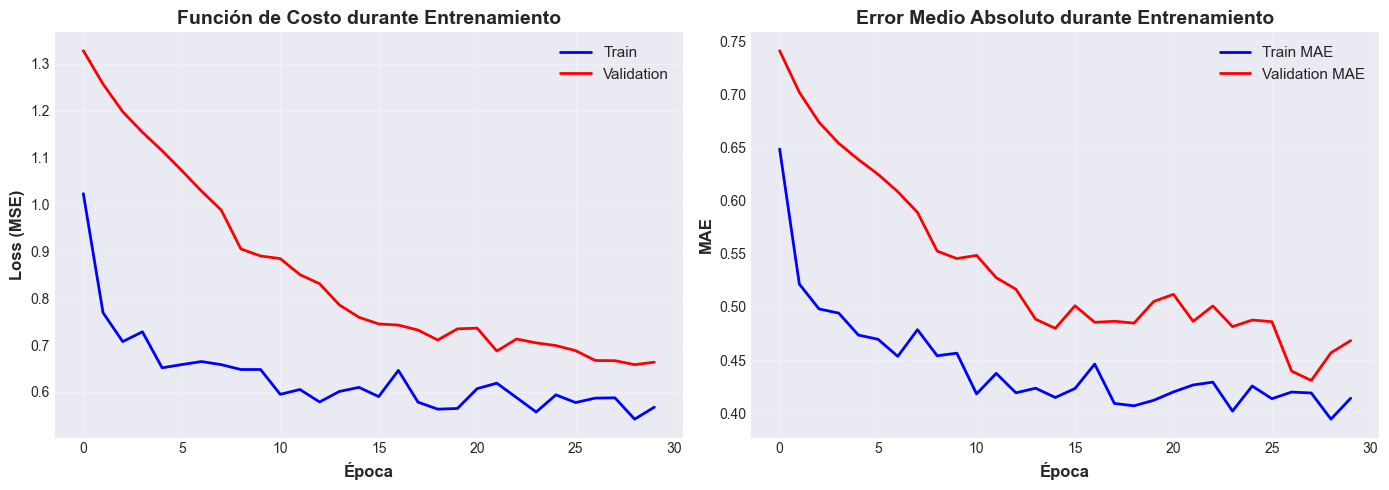


 *Gráfica 1: Curvas de entrenamiento y diagnóstico overfitting


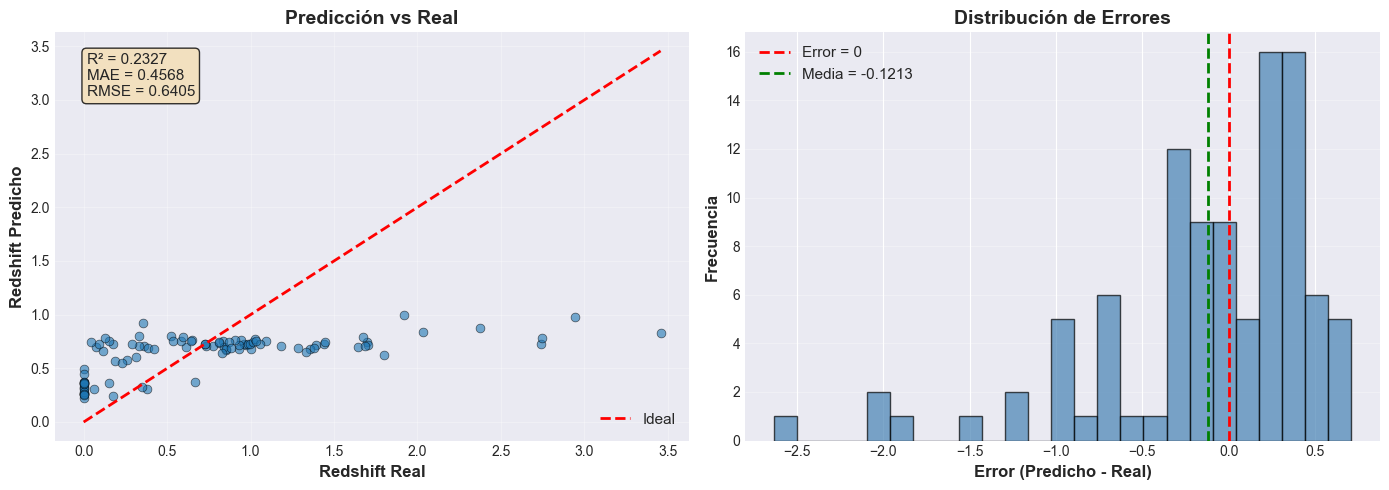

 *Gráfica 2: Calidad de predicción
Diagnóstico...

 *Análisis de Overfitting:
   Train Loss final: 0.567513
   Val Loss final:   0.663418
   Gap (diferencia): 0.095904
   Overfitting moderado
   → Puede mejorar con ajuste de hiperparámetros


In [9]:
# BLOQUE 5: EVALUACIÓN Y VISUALIZACIONES PARA POSIBLE OPTIMIZACIÓN
    #Vamos a enfocarnos en visualizaciones que realmente ayuden a tomar decisiones para optimizar el modelo.

# Hacer predicciones
y_pred = model.predict(X_test, verbose=0).ravel()

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Métricas finales:")
print(f"   MAE:  {mae:.6f}") # Mean Absolute Error
print(f"   RMSE: {rmse:.6f}") # Mean Squared Error
print(f"   R²:   {r2:.4f}")

# Gráfica 1 para ver si tenemos overfitting o incluso lo contario (underfitting)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss (MSE)
axes[0].plot(history.history['loss'], label='Train', linewidth=2, color='blue')
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2, color='red')
axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Función de Costo durante Entrenamiento', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2, color='blue')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Error Medio Absoluto durante Entrenamiento', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('01_curvas_entrenamiento.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n *Gráfica 1: Curvas de entrenamiento y diagnóstico overfitting")

# Gráfica 2 para ver que tan buenas son las predicciones.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicción vs Real
axes[0].scatter(y_test, y_pred, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
axes[0].plot([mn, mx], [mn, mx], 'r--', linewidth=2, label='Ideal')
axes[0].set_xlabel('Redshift Real', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Redshift Predicho', fontsize=12, fontweight='bold')
axes[0].set_title('Predicción vs Real', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}', 
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Distribución de errores
residuos = y_pred - y_test
axes[1].hist(residuos, bins=25, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[1].axvline(np.mean(residuos), color='green', linestyle='--', linewidth=2, 
                label=f'Media = {np.mean(residuos):.4f}')
axes[1].set_xlabel('Error (Predicho - Real)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('02_calidad_prediccion.png', dpi=300, bbox_inches='tight')
plt.show()

print(" *Gráfica 2: Calidad de predicción")

print("Diagnóstico...")

train_loss_final = history.history['loss'][-1]
val_loss_final = history.history['val_loss'][-1]
gap = val_loss_final - train_loss_final

print(f"\n *Análisis de Overfitting:")
print(f"   Train Loss final: {train_loss_final:.6f}")
print(f"   Val Loss final:   {val_loss_final:.6f}")
print(f"   Gap (diferencia): {gap:.6f}")

if gap > 0.3:
    print("   Overfitting detectado")
    print("   → Recomendación: aumentar Dropout o regularización L2")
elif gap < 0.05:
    print("   Buen balance entre train y validation")
else:
    print("   Overfitting moderado")
    print("   → Puede mejorar con ajuste de hiperparámetros")